# Import packages

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib
from numpy import sort

pd.options.display.max_columns = None

# Load Dataset

In [24]:
# https://www.kaggle.com/datasets/gagasrock/car-quality-prediction?select=Cars+Dataset.csv

In [2]:
cars_df = pd.read_csv('Cars Dataset.csv')

# Explore Cars Dataset


### Price is the response variable, it can be <br> 0: Cheap <br> 1: Average <br> 2: High



We can see that most cars in our dataset are Cheap (0) followed by Average (1) 
and there are very few with High (2) price


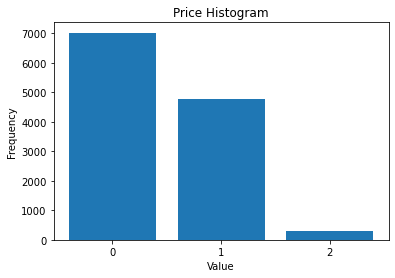

In [3]:
arr = cars_df['Price']
print("\n\nWe can see that most cars in our dataset are Cheap (0) followed by Average (1) \nand there are very few with High (2) price")
labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Price Histogram')
plt.show()

In [4]:
print("\n\nThe number of missing values is: ", cars_df.isnull().sum().sum(),"\n\n")



The number of missing values is:  0 




In [5]:
cars_df.head()

,YEAR,MAKE,MODEL,CONDITION,TRANSMISSION,CYLINDERS,FUEL,ODOMETER,ENGINE POWER,MILAGE,Price
0,2011,chevrolet,camaro,Excellent,Automatic,6,gas,12200,Avg CC,6,0
1,2012,chrysler,town & country,Excellent,Manual,6,gas,111000,Low CC,11,0
2,2009,jeep,liberty,Excellent,Manual,6,gas,68650,Low CC,49,0
3,2011,buick,lacrosse,Excellent,Manual,6,gas,123562,High CC,40,0
4,2008,chevrolet,cobalt,Excellent,Automatic,4,gas,138001,Avg CC,33,0


In [6]:
cars_df.dtypes

YEAR             int64
MAKE            object
MODEL           object
CONDITION       object
TRANSMISSION    object
CYLINDERS        int64
FUEL            object
ODOMETER         int64
ENGINE POWER    object
MILAGE           int64
Price            int64
dtype: object

## XGBoost does not support categorical variables so we will need to transform those columns using One Hot Encoding

![title](ohe_example.png)



Some of the categorical variables are quite simple, having only 2 possible values




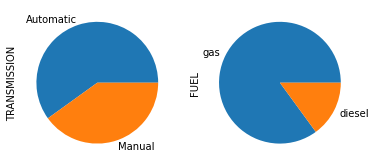

In [7]:
print("\n\nSome of the categorical variables are quite simple, having only 2 possible values\n\n")
fig, (ax1, ax2) = plt.subplots(1, 2)
TRANSMISSION = cars_df['TRANSMISSION'].value_counts().plot(kind='pie', layout=[1,2], ax=ax1)
CONDITION = cars_df['FUEL'].value_counts().plot(kind='pie', layout=[2,2], ax=ax2)

And some of the categorical variables have many different values


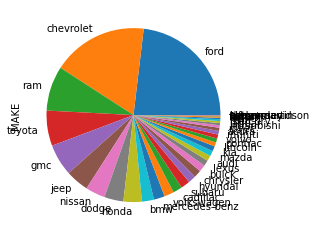

In [8]:
print("And some of the categorical variables have many different values")
MAKE = cars_df['MAKE'].value_counts().plot(kind='pie')

In [9]:
cars_df2=pd.get_dummies(data=cars_df,drop_first=True)
print("\n\nThe original dataset has ",len(cars_df.columns)-1," columns")
print("After One Hot Encoding we now have ",len(cars_df2.columns)-1," columns\n\n")



The original dataset has  10  columns
After One Hot Encoding we now have  3122  columns




In [10]:
print("\n\nYou can see how a new column was created for every value of MAKE \nNow that these categorical variables have been transformed to binary ones, \nwe will be able to use them in XGBoost\n")
cars_df2.head()



You can see how a new column was created for every value of MAKE 
Now that these categorical variables have been transformed to binary ones, 
we will be able to use them in XGBoost



YEAR  CYLINDERS  ODOMETER  MILAGE  Price  MAKE_alfa-romeo  \
0  2011          6     12200       6      0                0   
1  2012          6    111000      11      0                0   
2  2009          6     68650      49      0                0   
3  2011          6    123562      40      0                0   
4  2008          4    138001      33      0                0   

   MAKE_aston-martin  MAKE_audi  MAKE_bmw  MAKE_buick  MAKE_cadillac  \
0                  0          0         0           0              0   
1                  0          0         0           0              0   
2                  0          0         0           0              0   
3                  0          0         0           1              0   
4                  0          0         0           0              0   

   MAKE_chevrolet  MAKE_chrysler  MAKE_datsun  MAKE_dodge  MAKE_ferrari  \
0               1              0            0           0             0   
1               0              1            0           0             0   
2               0              0            0           0             0   
3               0              0            0           0             0   
4               1              0            0           0             0   

   MAKE_fiat  MAKE_ford  MAKE_gmc  MAKE_harley-davidson  MAKE_hennessey  \
0          0          0         0                     0               0   
1          0          0         0                     0               0   
2          0          0         0                     0               0   
3          0          0         0                     0               0   
4          0          0         0                     0               0   

   MAKE_honda  MAKE_hyundai  MAKE_infiniti  MAKE_jaguar  MAKE_jeep  MAKE_kia  \
0           0             0              0            0          0         0   
1           0             0              0            0          0         0   
2           0             0              0            0          1         0   
3           0             0              0            0          0         0   
4           0             0              0            0          0         0   

   MAKE_lexus  MAKE_lincoln  MAKE_mazda  MAKE_mercedes-benz  MAKE_mercury  \
0           0             0           0                   0             0   
1           0             0           0                   0             0   
2           0             0           0                   0             0   
3           0             0           0                   0             0   
4           0             0           0                   0             0   

   MAKE_mini  MAKE_mitsubishi  MAKE_nissan  MAKE_pontiac  MAKE_ram  \
0          0                0            0             0         0   
1          0                0            0             0         0   
2          0                0            0             0         0   
3          0                0            0             0         0   
4          0                0            0             0         0   

   MAKE_rover  MAKE_saturn  MAKE_subaru  MAKE_toyota  MAKE_volkswagen  \
0           0            0            0            0                0   
1           0            0            0            0                0   
2           0            0            0            0                0   
3           0            0            0            0                0   
4           0            0            0            0                0   

   MAKE_volvo  MODEL_(e70) x5  MODEL_- f 250 super duty  \
0           0               0                         0   
1           0               0                         0   
2           0               0                         0   
3           0               0                         0   
4           0               0                         0   

   MODEL_- mx -5 miata rf g.tour  MODEL_/ cc r-line  MODEL_/ sienna le  \
0                              0                  

### X contains the predictor variables, which is all columns except for Price <br> Y contains the response variable, Price

In [11]:
X = cars_df2.loc[:, cars_df2.columns != 'Price']
Y = cars_df2.loc[:, cars_df2.columns == 'Price']

### We split the data into train (80%) and test (20%) sets

In [12]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

### Fit the XGBoost Model

In [13]:
%%time
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)
Accuracy: 92.67%
CPU times: user 6min 49s, sys: 6.19 s, total: 6min 55s
Wall time: 58.3 s


### Features = 3122 <br><br> Accuracy = 92.67% <br><br> Run time = 7 mins

### Since we have so many features, we will see how we can reduce them

### Which features are most important in predicting Price?

In [14]:
df1 = pd.DataFrame({'Column Name':X.columns, 'Feature Importance (%)':100*model.feature_importances_.round(4)})
print("\n\nView the top 10 features")
df1.sort_values(by='Feature Importance (%)', ascending=False)[:10].reset_index(drop=True)



View the top 10 features


,Column Name,Feature Importance (%)
0,FUEL_gas,7.34
1,CYLINDERS,6.25
2,YEAR,4.56
3,ENGINE POWER_Low CC,3.79
4,MODEL_explorer,2.12
5,MAKE_volkswagen,2.03
6,MODEL_wrangler,1.92
7,MAKE_ram,1.56
8,MAKE_dodge,1.38
9,MODEL_escalade,1.28


In [15]:
least_imp = df1[df1['Feature Importance (%)']==0]['Column Name']
print("\nThere are " ,len(least_imp), " columns with feature importance of 0 so we will remove them")
X_new = X.drop(least_imp, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=test_size, random_state=seed)
print("We are left with ", len(X_new.columns)," columns")


There are  2944  columns with feature importance of 0 so we will remove them
We are left with  178  columns


### Starting with 178 columns, we will retrain the model removing 1 column each time 
### We will check the accuracy after each iteration
### The goal is to reduce the number of features while keeping a high accuracy score

In [16]:
# use feature importance for feature selection

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 92.67%
Thresh=0.000, n=178, Accuracy: 92.67%
Thresh=0.000, n=177, Accuracy: 92.80%
Thresh=0.001, n=176, Accuracy: 92.80%
Thresh=0.001, n=175, Accuracy: 92.55%
Thresh=0.001, n=174, Accuracy: 92.72%
Thresh=0.001, n=173, Accuracy: 92.84%
Thresh=0.001, n=172, Accuracy: 92.55%
Thresh=0.001, n=171, Accuracy: 92.76%
Thresh=0.001, n=170, Accuracy: 92.84%
Thresh=0.001, n=169, Accuracy: 92.76%
Thresh=0.001, n=168, Accuracy: 92.76%
Thresh=0.001, n=167, Accuracy: 92.59%
Thresh=0.001, n=166, Accuracy: 92.59%
Thresh=0.001, n=165, Accuracy: 92.59%
Thresh=0.001, n=164, Accuracy: 92.59%
Thresh=0.001, n=163, Accuracy: 92.55%
Thresh=0.001, n=162, Accuracy: 92.55%
Thresh=0.001, n=161, Accuracy: 92.67%
Thresh=0.001, n=160, Accuracy: 92.63%
Thresh=0.001, n=159, Accuracy: 92.63%
Thresh=0.001, n=158, Accuracy: 92.55%
Thresh=0.001, n=157, Accuracy: 92.63%
Thresh=0.001, n=156, Accuracy: 92.63%
Thresh=0.001, n=155, Accuracy: 92.96%
Thresh=0.001, n=154, Accuracy: 92.67%
Thresh=0.001, n=153, Accuracy: 92

### As n, the number of features, decreases typically the accuracy decreases as well
### We want to find the best n where we still have a high accuracy but not as many features

### We are able to keep an accuracy of 92.51% while only keeping 18 features
### This is a great as we started with 92.67% and had 3,122 features

In [17]:
top18 = df1.sort_values(by='Feature Importance (%)', ascending=False)[:18]
print("\nThese are the top 18 features in order")
top18.reset_index(drop=True)


These are the top 18 features in order


,Column Name,Feature Importance (%)
0,FUEL_gas,7.34
1,CYLINDERS,6.25
2,YEAR,4.56
3,ENGINE POWER_Low CC,3.79
4,MODEL_explorer,2.12
5,MAKE_volkswagen,2.03
6,MODEL_wrangler,1.92
7,MAKE_ram,1.56
8,MAKE_dodge,1.38
9,MODEL_escalade,1.28


In [18]:
X_top18 = X[X.columns[X.columns.isin(top18['Column Name'].tolist())]]
X_train, X_test, y_train, y_test = train_test_split(X_top18, Y, test_size=test_size, random_state=seed)

In [19]:
%%time
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)
Accuracy: 92.51%
CPU times: user 9.64 s, sys: 1.63 s, total: 11.3 s
Wall time: 1.92 s


### Features = 3122 <br><br> Accuracy = 92.67% <br><br> Run time = 7 mins

### Features = 18 <br><br> Accuracy = 92.51%  <br><br> Run time = 11 seconds

### View Decision Trees from XGBoost

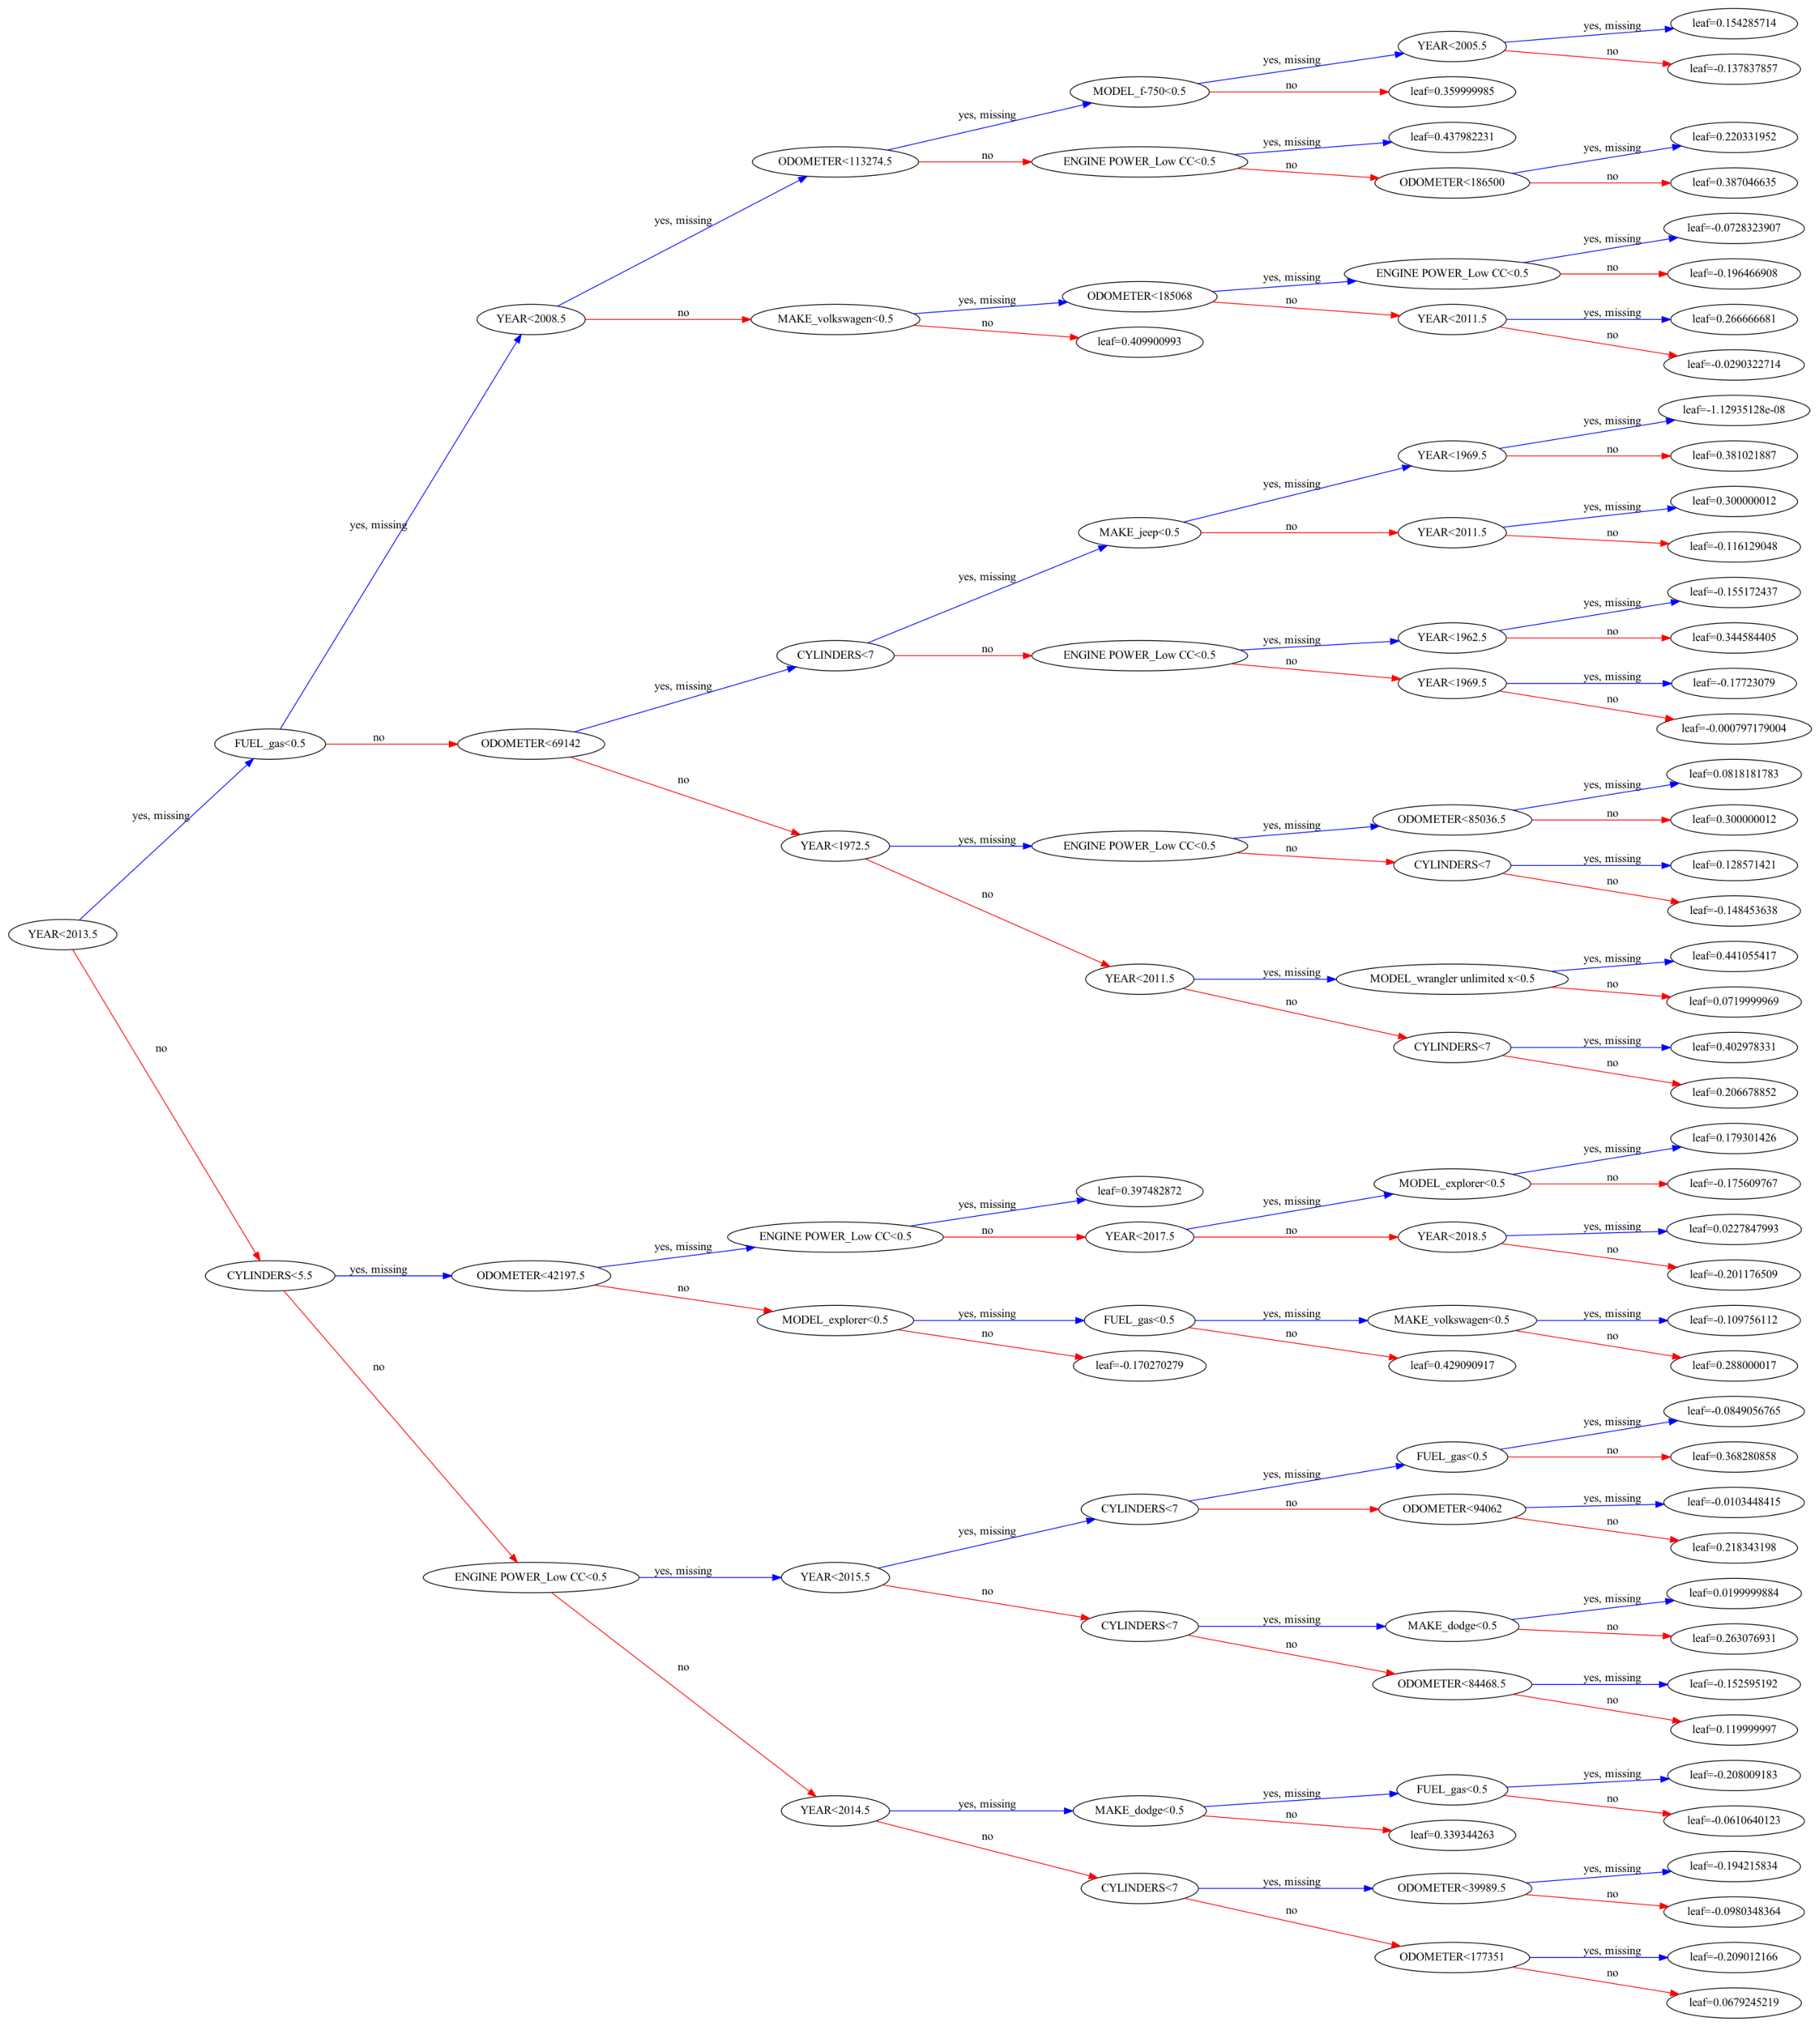

In [20]:
xgb.plot_tree(model, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(50, 50)

## Using a decision tree regressor instead of XGBoost

In [21]:
%%time

# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

ypred = regressor.predict(X_test)
# accuracy:
print("Accuracy: ",round(100*sum(ypred==y_test['Price'].tolist())/len(ypred),2),"%")

Accuracy:  88.74 %
CPU times: user 25 ms, sys: 3.23 ms, total: 28.2 ms
Wall time: 28.3 ms


### Using the same 18 features for the decision tree regressor
### Features = 18 <br><br> Accuracy = 88.74 %  <br><br> Run time = 1 seconds

### Viewing the whole tree is hard to read

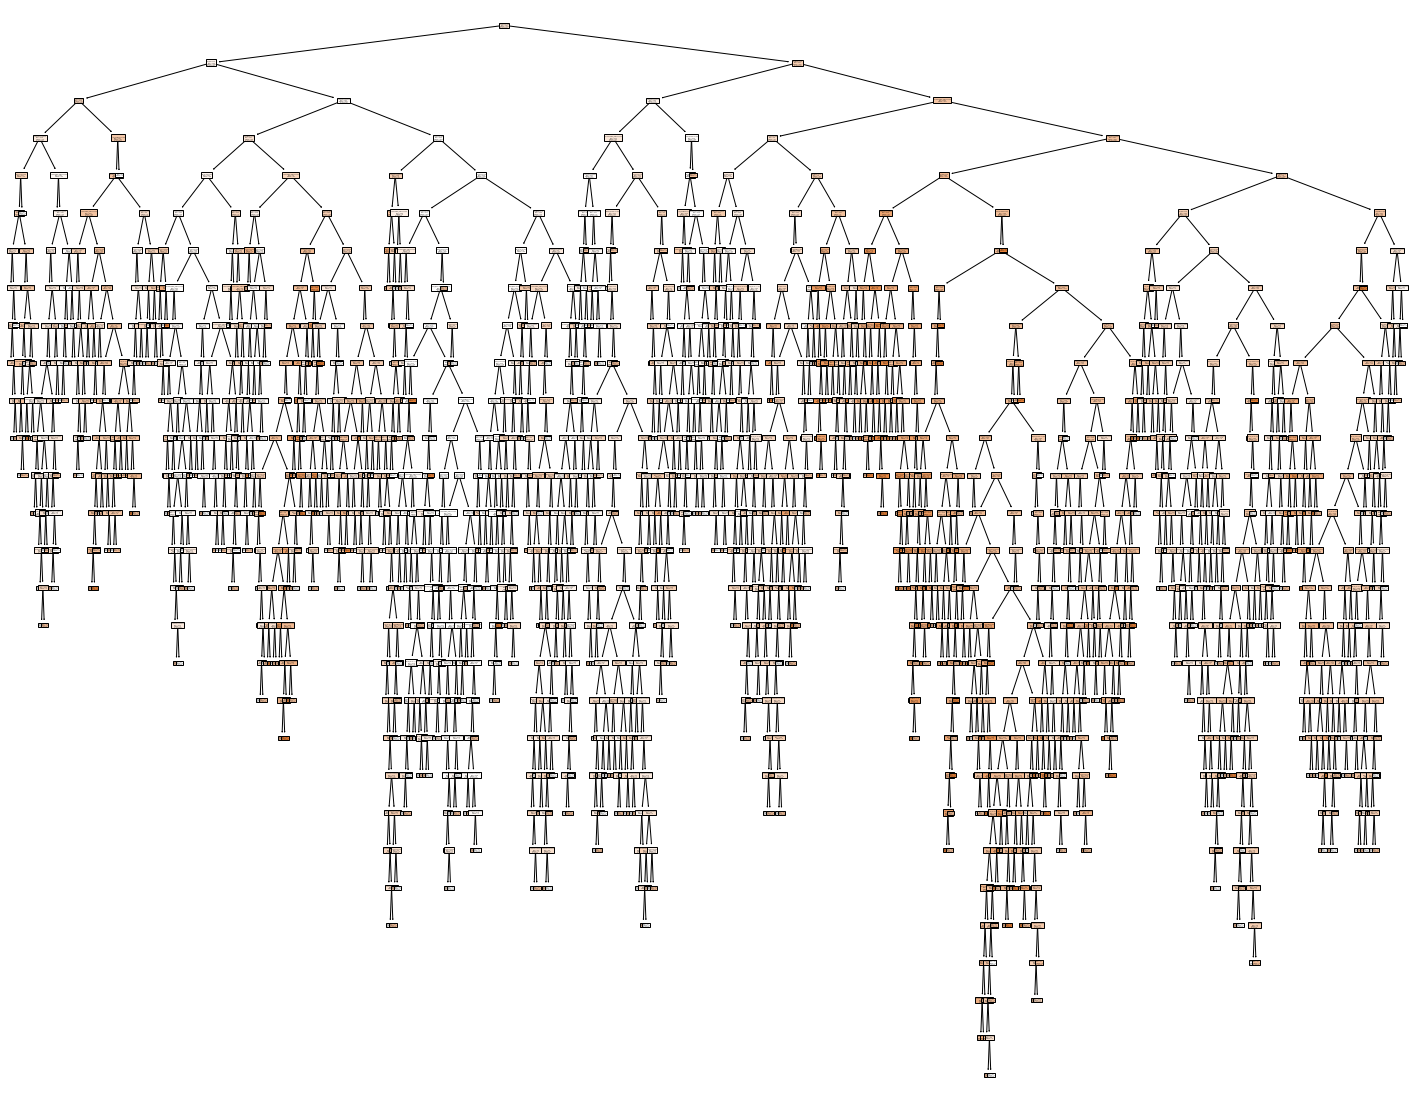

In [22]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regressor,
                   feature_names=X_train.columns,  
                   class_names=X_test.columns,
                   filled=True)

### Just taking a look at the first few levels of the tree

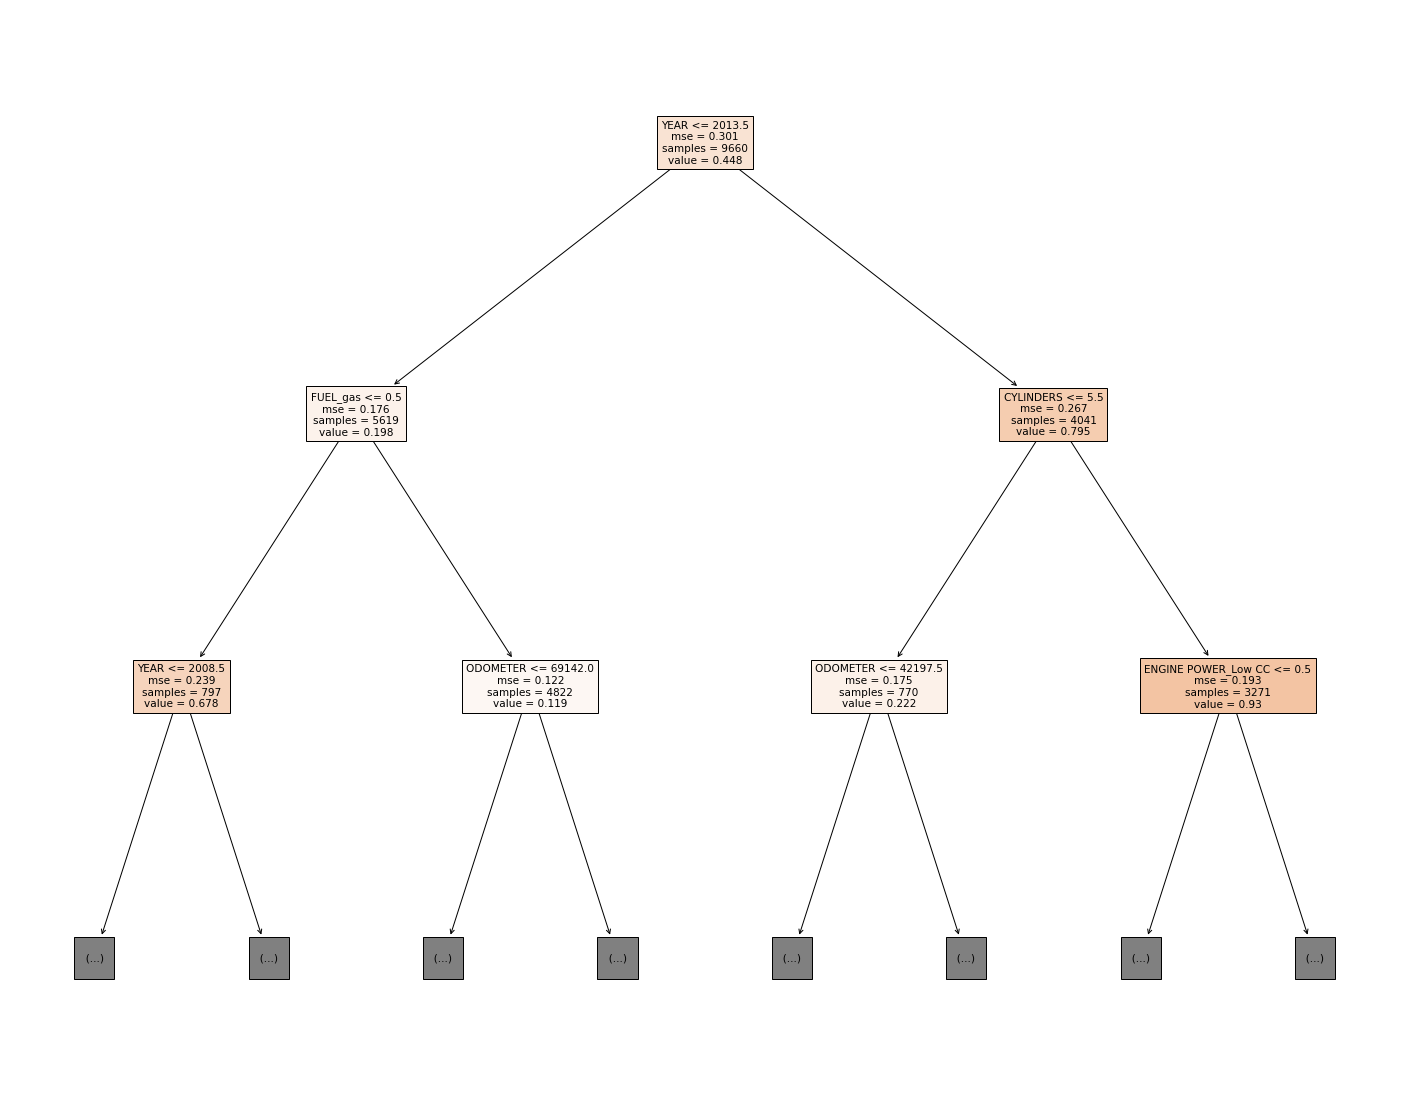

In [23]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regressor, max_depth=2,
                   feature_names=X_train.columns,  
                   class_names=X_test.columns,
                   filled=True)